In [1]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees

In [2]:
mc_file = uproot.open("/eos/user/h/hsharma/XicMLTrees/MC/XicSignal.root")
mc_file.keys()
pd_mc = mc_file["XicSignal"].arrays(library="pd")

In [3]:
pd_mc.columns ## the suffix MC indicates the generated quantity

Index(['fM', 'fPt', 'fCpa', 'fCpaXY', 'fCt', 'fEta', 'fPhi', 'fDecayLength',
       'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
       'fErrorDecayLength', 'fErrorDecayLengthXY', 'fChi2PCA',
       'fRSecondaryVertex', 'fCandidateSelFlag', 'fNSigTpcPi0', 'fNSigTpcPi2',
       'fNSigTpcPr0', 'fNSigTpcPr2', 'fNSigTpcKa1', 'fNSigTofPi0',
       'fNSigTofPi2', 'fNSigTofPr0', 'fNSigTofPr2', 'fNSigTofKa1'],
      dtype='object')

In [4]:
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

If bkg data sample is much larger than the signal one. This does not represent a problem, as the BDT is not sensitive to the relative abundances of the classes. However, to speed-up the training process, one should consider resonable amount (not too large/not too small) of bkg, e.g., 20-30% 

In [5]:
hdl_mc = TreeHandler("/eos/user/h/hsharma/XicMLTrees/MC/XicSignal.root", "XicSignal")
hdl_data = TreeHandler("/eos/user/h/hsharma/XicMLTrees/DATA/XicBkg.root", "XicBkg")
hdl_bkg = hdl_data.apply_preselections("fM < 2.42 or fM > 2.52", inplace=False)
print('Size of samples \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))
print('----------------------------------')



# Samples for training
fractionData=0.1 # this is the fraction of total data used in training 
hdl_bkg.shuffle_data_frame(frac=fractionData, inplace=True)
print('Size of samples for training \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))

Size of samples 
Data =  278600 , MC =  2359
----------------------------------
Size of samples for training 
Data =  27860 , MC =  2359


In [6]:
## now we remove the background from the data sample
hdl_data.apply_preselections("fM > 2.42 or fM < 2.52", inplace=True)

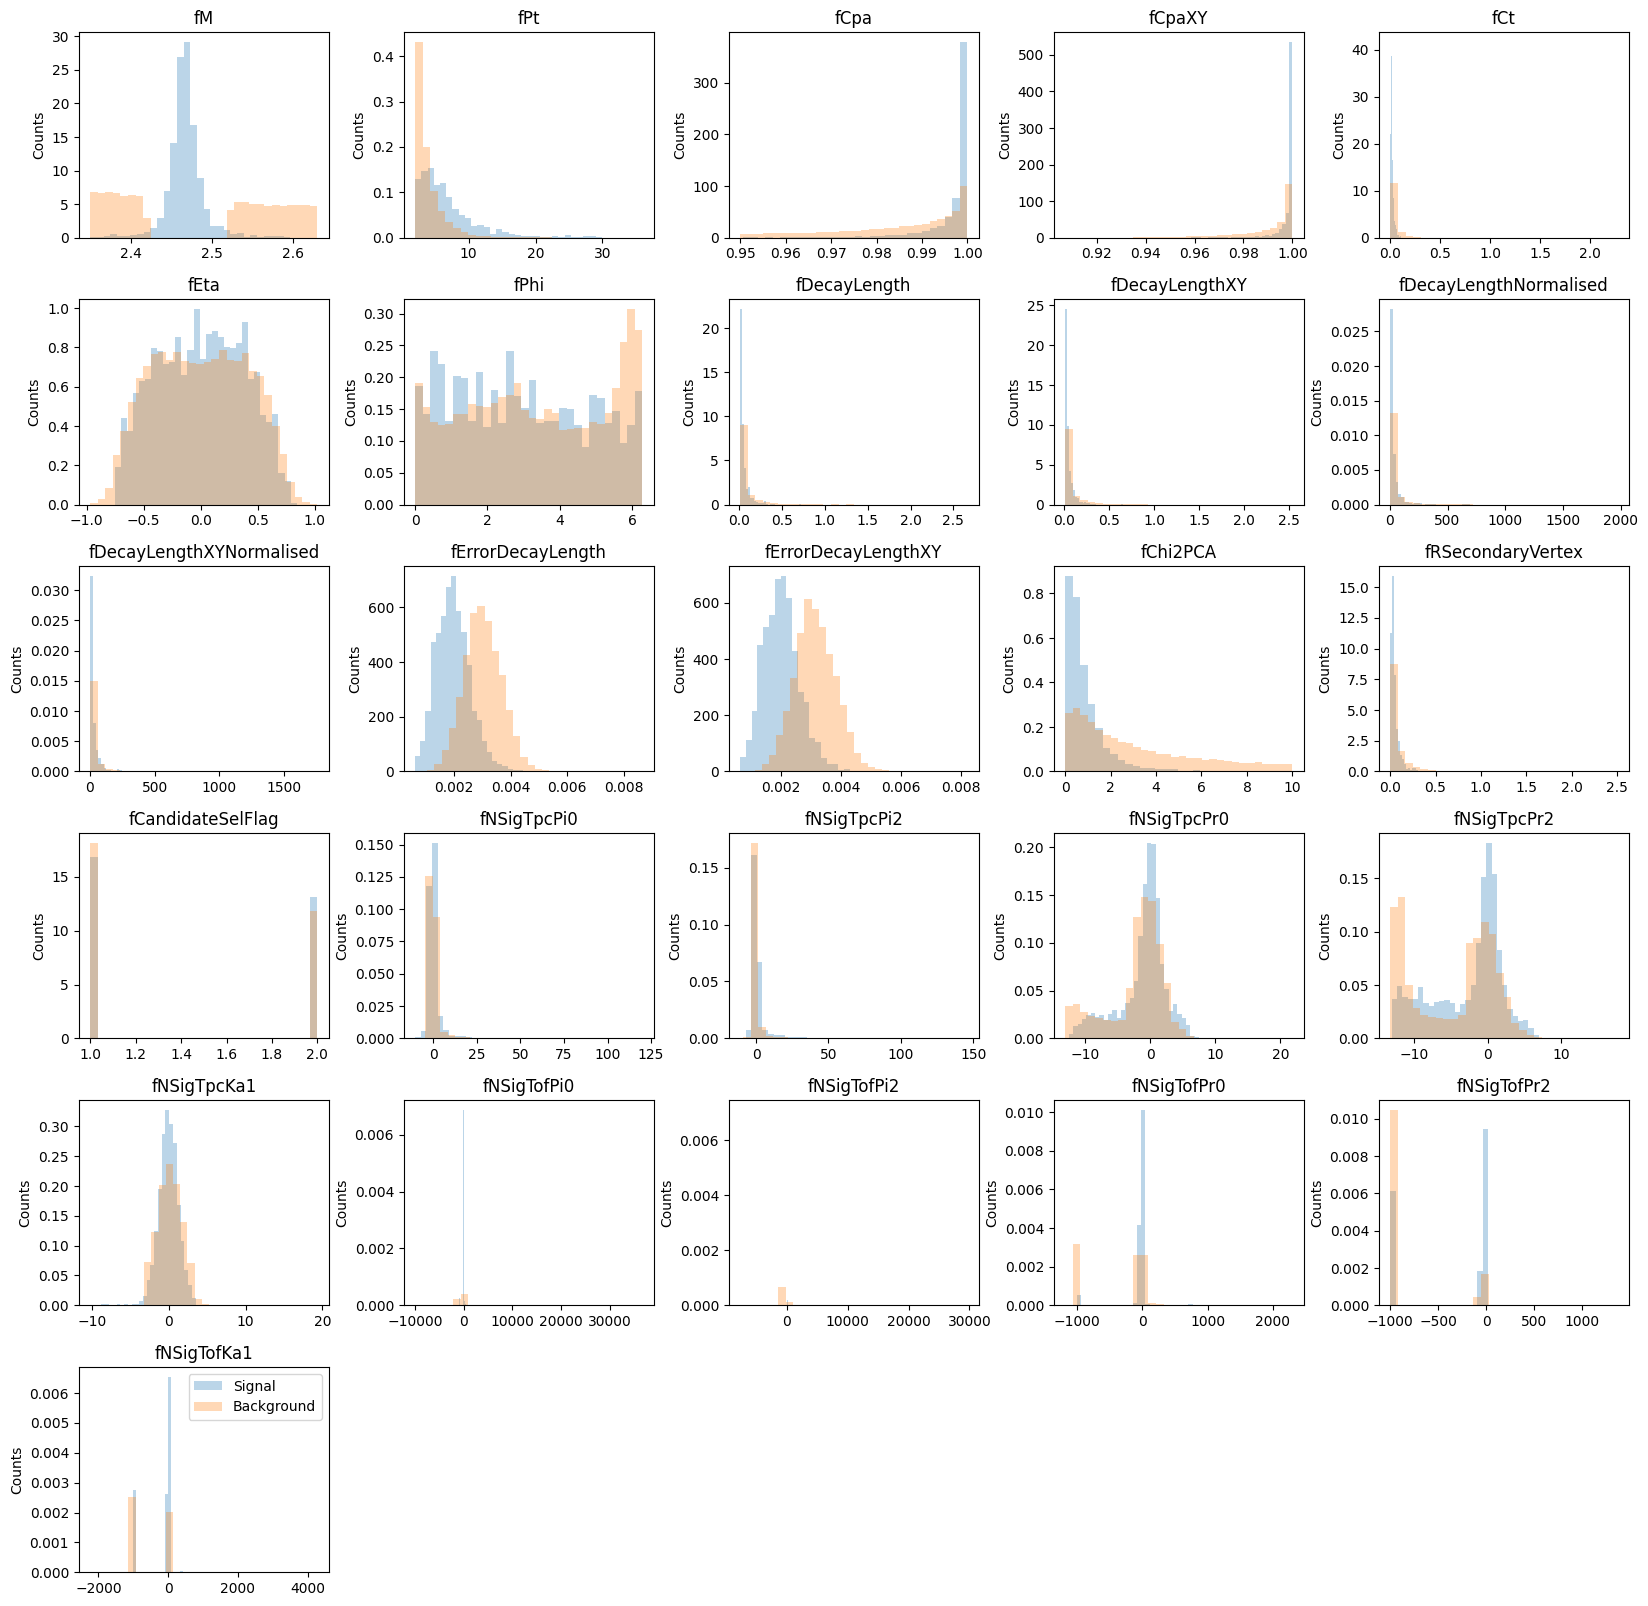

In [7]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised', 
                'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1']


## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
                      bins=30, labels=['Signal', 'Background'],
                      log=0, density=True, figsize=(20, 20), alpha=0.3, grid=False);

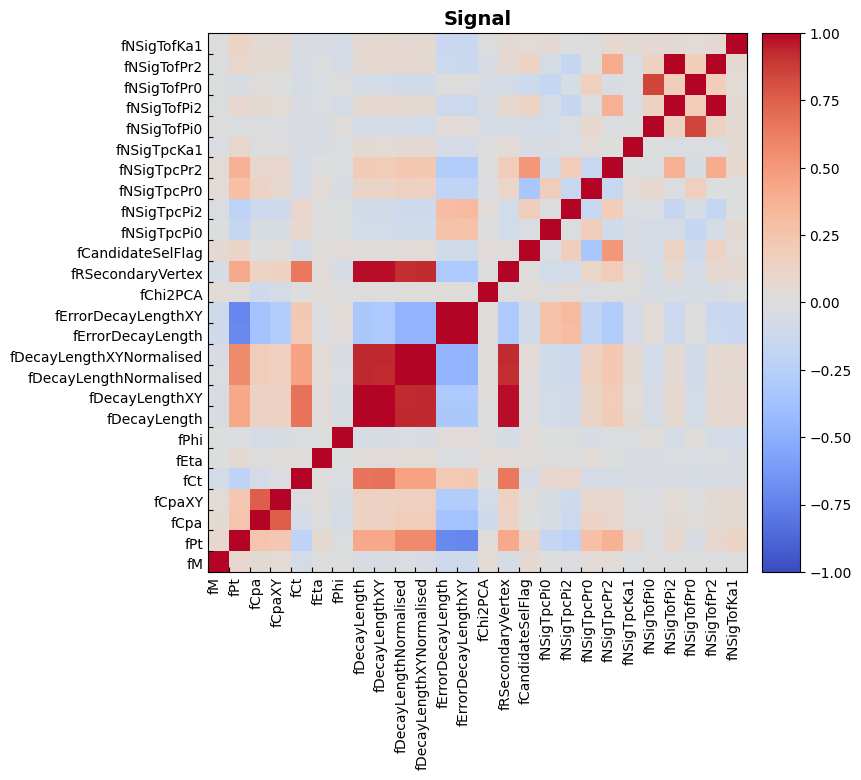

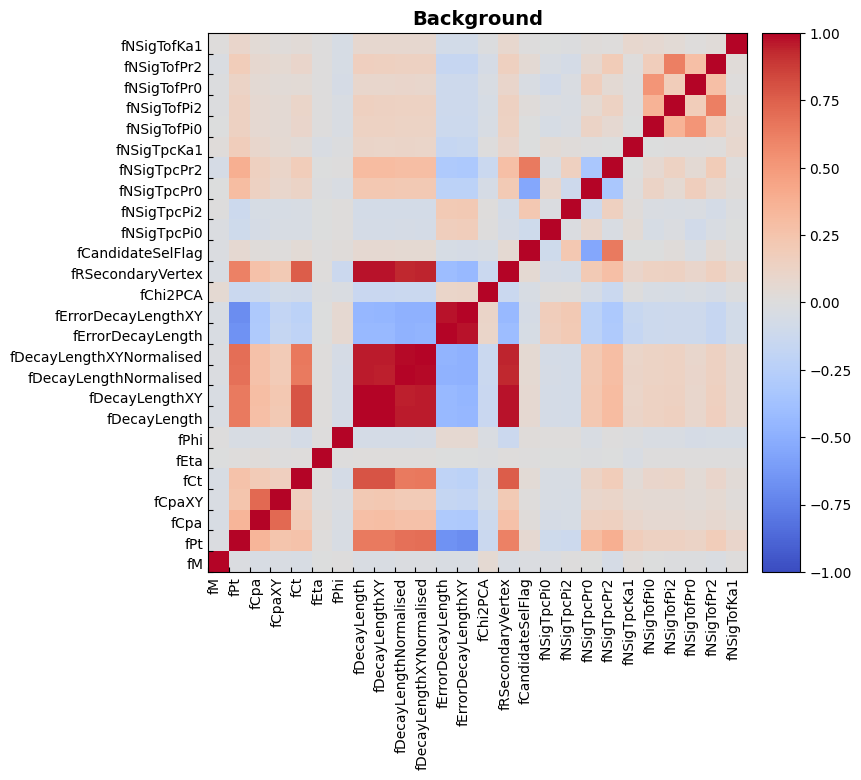

In [10]:
plot_utils.plot_corr([hdl_mc, hdl_bkg], cols_to_be_compared, labels=['Signal', 'Background']);

Considerations? Doubts? Let's now define the training columns and build the training sample


In [9]:
# training_cols = ['fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised','fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
#                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1', 'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']

# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
training_cols = ['fCpa','fCpaXY',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1',
                 'fErrorDecayLength' , 'fErrorDecayLengthXY'
                ]
# train_test_data is a combined dataset of data and MC
train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.5, random_state=42)

print('Size of train sample: ', len(train_test_data[0]))
print('Size of test sample: ', len(train_test_data[3]))


Size of train sample:  15109
Size of test sample:  15110


We will use the BDT of XGBoost (https://github.com/dmlc/xgboost): boosting is implemented with a gradient descent method. It features few hyperparameters that can be tuned to improve the performance and reduce the overfitting, even if the algorithm works smoothly out of the box.



In [11]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(84,24,99), random_state=1,max_iter=400)
model_hdl = ModelHandler(clf_NN, training_cols)

In [42]:
model_hdl.fit(train_test_data[0], train_test_data[1])

## Optimize the model on the provided data

In [ ]:
from optuna.samplers import RandomSampler

N_JOBS=8

parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, parameter_space, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

[I 2023-08-04 17:21:35,397] A new study created in memory with name: no-name-15774325-9771-42a0-91e9-2eec4239fbef
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

In [ ]:
model_hdl.fit(train_test_data[0], train_test_data[1])

Training Done! Let's apply the model to the test sample

Two peaks clearly distinguishable?: will they be corresponding to the signal and the background? Let's plot the two distribution separately

In [13]:
score_test = model_hdl.predict(train_test_data[2],output_margin=False)
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

Two peaks clearly distinguishable: will they be corresponding to the signal and the background? Let's plot the two distribution separately

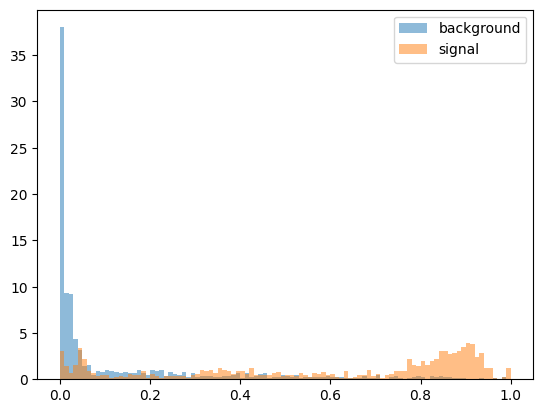

In [15]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


Well separated peaks on the test set! This is what we want.
Now we can evaluate the performance on the test set: we can use the ROC curve, which is built by plotting
the true positive rate (TPR) against the false negative rate (FPR) as a function of the
score threshold, where TPR and FPR are defined as:


$TPR=\frac{\sum TP}{\sum TP + \sum FN} \hspace{2cm} FPR=\frac{\sum FP}{\sum FP + \sum TN} $

and in our case represent the signal selection and the background rejection
efficiencies respectively as a function of the score. The most common way employed to evaluate the performance of a BDT is to
compute the area under the ROC curve, called AUC: a perfect classifier will have
a ROC AUC equal to 1, whereas a random classifier will have a ROC AUC equal
to 0.5.



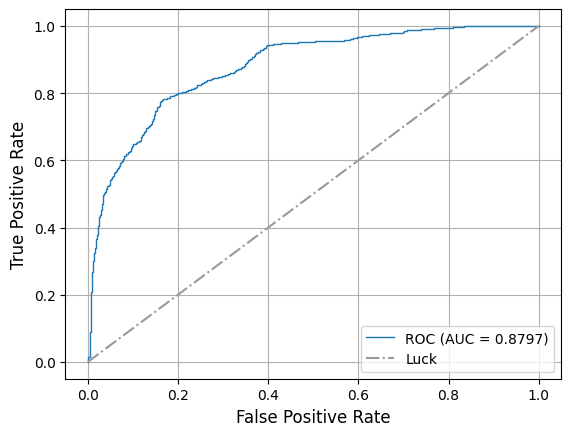

In [16]:
plot_utils.plot_roc(train_test_data[3], score_test);

Repeat this exercise with the training set: what do you get?

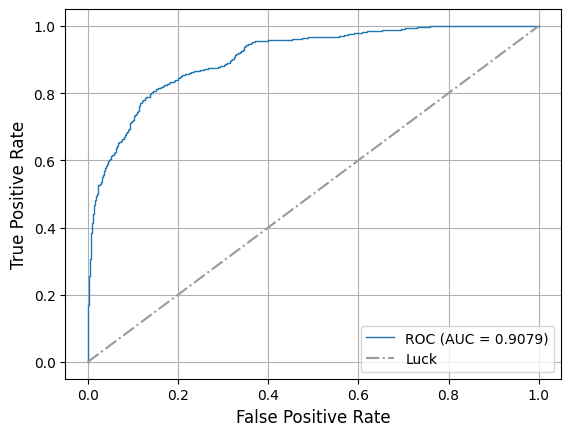

In [17]:
score_train = model_hdl.predict(train_test_data[0],output_margin=False)
plot_utils.plot_roc(train_test_data[1], score_train);

Training ROC-AUC is slightly higher than the test set one. This is a systematic behaviour due to the small presence of overfitting. We can see it also by plotting the BDT output for the training and test set distributions

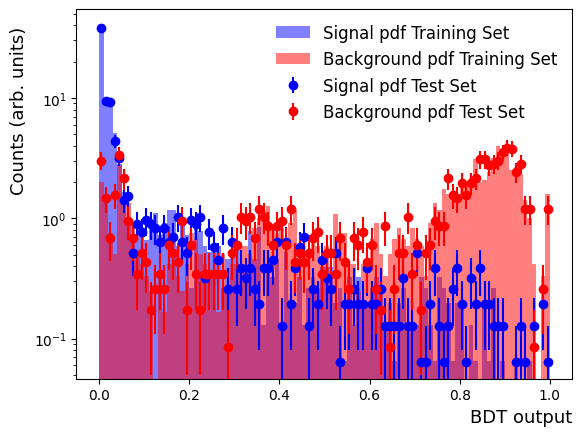

In [18]:
plot_utils.plot_output_train_test(model_hdl, train_test_data, density=True, bins=100, logscale=True,output_margin=False);

Now, before applying the BDT to data we can have a look at which variables are relevant for the training. We will use the feature importance implemented in the SHAP library (https://github.com/slundberg/shap). In the context of machine learning, the Shapley value is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are
more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

In hipe4ml the function plot_feat_imp implements the algorithm: try to use it!

Two plots given: how to interpret them?

**Bonus** : repeat the training using a different model and compare its performance with the XGB BDT. All the sklearn and keras (NN) models can be used to feed the ModelHandler

### Applying the BDT

Now that the model is tested we can use it to classify the real data sample. Try to evaluate the invariant mass as a function of the score distribution

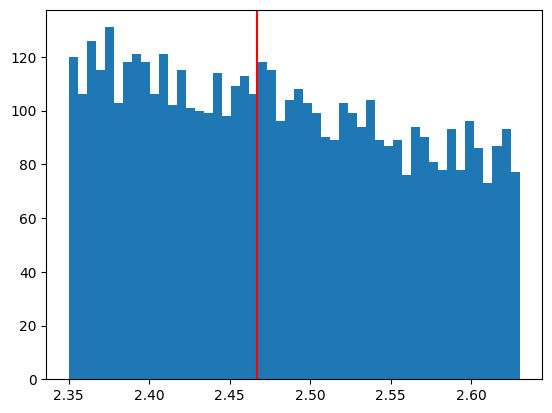

In [24]:
hdl_data.apply_model_handler(model_hdl,output_margin=False)
plt.hist(hdl_data.apply_preselections("model_output>0.85", inplace=False)["fM"], bins=50);
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')

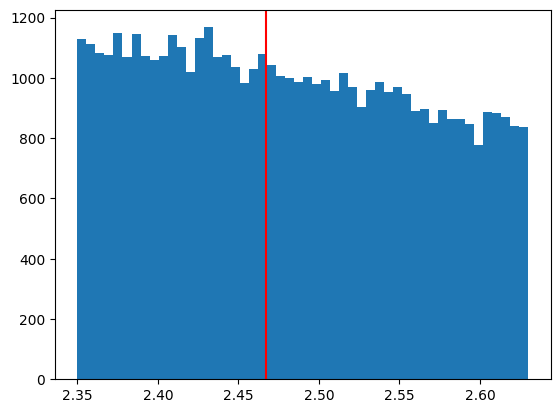

In [336]:
plt.hist(hdl_data.apply_preselections("model_output>-2", inplace=False)["fM"], bins=50);
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')

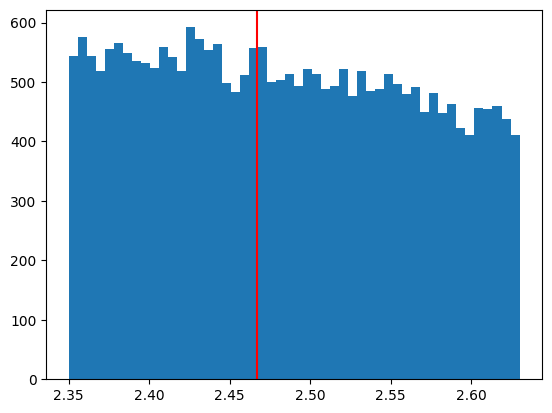

In [337]:
plt.hist(hdl_data.apply_preselections("model_output>-1", inplace=False)["fM"], bins=50);
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')

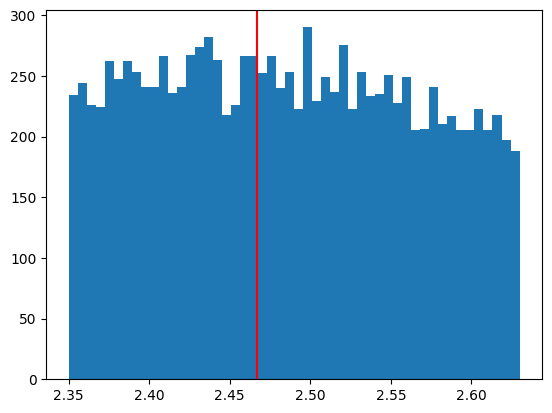

In [338]:
plt.hist(hdl_data.apply_preselections("model_output>0", inplace=False)["fM"], bins=50);
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')

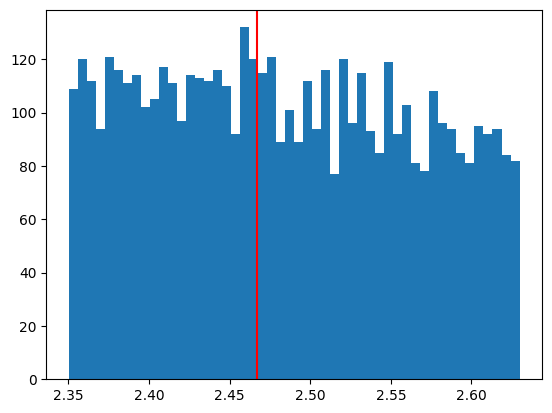

In [339]:
plt.hist(hdl_data.apply_preselections("model_output>1", inplace=False)["fM"], bins=50);
plt.axvline(2.467, 0, 1, label='pyplot vertical line',color='r')

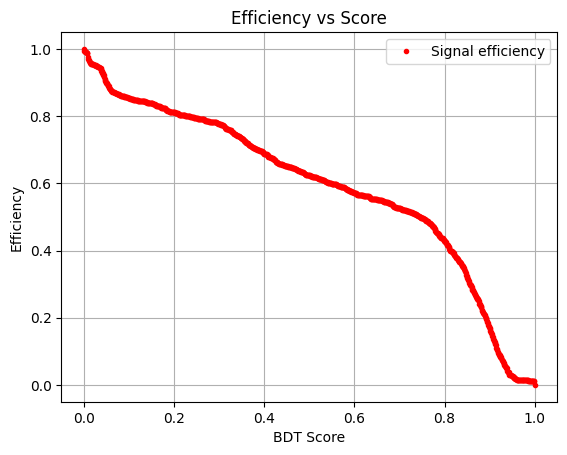

In [25]:
### hipe4ml has a function to do that! 
eff_array, score_array = analysis_utils.bdt_efficiency_array(train_test_data[3], score_test, 1000)
plot_utils.plot_bdt_eff(score_array, eff_array);

In [ ]:
## Now we can try to fit the invariant mass spectrum

In [ ]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 1.673, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.legend()
    plt.xlabel('$M_{\Lambda\pi}$ $(\mathrm{GeV/}\it{c}^2)$')
    plt.ylabel('Counts')
    plt.show()


In [ ]:
fit_invmass(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [ ]:
### you can also use some packages for implementing ROOT like plots in python
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [ ]:
fit_invmass(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [ ]:
#### reset matplotlib style if needed
plt.style.use('default')